In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from sea_breeze import load_model_data
from sea_breeze import sea_breeze_funcs 
import datetime as dt
import pandas as pd
import tqdm
import hvplot.xarray
import metpy.calc as mpcalc
import metpy.units as units

In [2]:
from dask.distributed import Client
client = Client()
client

2024-12-27 11:13:28,630 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-12-27 11:13:28,639 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-12-27 11:13:28,644 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38377 instead
  warnings.warn(


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0035.gadi.nci.org.au/8454/proxy/38377/status,
Dashboard: /node/gadi-cpu-bdw-0035.gadi.nci.org.au/8454/proxy/38377/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39693,Workers: 28
Dashboard: /node/gadi-cpu-bdw-0035.gadi.nci.org.au/8454/proxy/38377/status,Total threads: 28
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44379,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0035.gadi.nci.org.au/8454/proxy/38671/status,Memory: 0 B
Nanny: tcp://127.0.0.1:43635,


In [3]:
lat_slice=slice(-45.7,-6.9)
lon_slice=slice(108,158.5)
# lat_slice = slice(-42,-36)
# lon_slice = slice(144,151)
t1="2016-01-01 01:00"
t2="2016-01-31 23:00"
hgt_slice=slice(0,4500)

In [10]:
# #Load ERA5 model level winds, BLH and static info
# chunks = {"time":{},"latitude":{},"longitude":{},"hybrid":-1}
# era5_wind, lsm = load_model_data.load_era5_ml_and_interp(
#         t1,
#         t2,
#         lat_slice,
#         lon_slice,
#         heights=hgt_slice,
#         chunks=chunks)
# era5_zmla = load_model_data.load_era5_variable(
#         ["blh"],
#         t1,
#         t2,
#         lon_slice,
#         lat_slice,
#         chunks=chunks)
# angle_ds = load_model_data.get_coastline_angle_kernel(
#     lsm,
#     compute=False,
#     lat_slice=lat_slice,
#     lon_slice=lon_slice,
#     path_to_load="/g/data/gb02/ab4502/coastline_data/era5_global_angles.nc")

#Load AUS2200 model level winds, BLH and static info
chunks = {"lev":-1,"time":1,"lat":-1,"lon":{}}
orog, lsm = load_model_data.load_aus2200_static(
    "mjo-elnino",
    lon_slice,
    lat_slice)
aus2200_va = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "va",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="lat",
        hgt_slice=hgt_slice),
          "1hr")
aus2200_ua = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "ua",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="lon",
        hgt_slice=hgt_slice),
          "1hr")
aus2200_zmla = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "zmla",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="time"),
          "1hr")
angle_ds = load_model_data.get_coastline_angle_kernel(
    lsm,
    compute=False,
    lat_slice=lat_slice,
    lon_slice=lon_slice,
    path_to_load="/g/data/gb02/ab4502/coastline_data/aus2200.nc")

#Calc SBI
aus2200_wind = xr.Dataset({"u":aus2200_ua,"v":aus2200_va})

In [11]:
aus2200_ua

<xarray.DataArray 'ua' (time: 743, lev: 36, lat: 1960, lon: 2550)>
dask.array<truediv, shape=(743, 36, 1960, 2550), dtype=float32, chunksize=(1, 36, 1960, 519), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 2.5 13.33 33.33 60.0 ... 3.96e+03 4.193e+03 4.433e+03
  * lat      (lat) float64 -45.7 -45.68 -45.66 -45.64 ... -6.951 -6.931 -6.911
  * lon      (lon) float64 108.0 108.0 108.1 108.1 ... 158.4 158.4 158.5 158.5
  * time     (time) datetime64[ns] 2016-01-01T01:00:00 ... 2016-01-31T23:00:00

In [5]:
sbi = sea_breeze_funcs.calc_sbi(era5_wind,
                            angle_ds,
                            subtract_mean=False,
                            height_method=height_method,
                            blh_da=era5_zmla["blh"]["blh"],
                            vert_coord="height")

<xarray.DataArray (time: 25, lat: 155, lon: 203)>
dask.array<amax-aggregate, shape=(25, 155, 203), dtype=int64, chunksize=(25, 40, 53), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -45.5 -45.25 -45.0 -44.75 ... -7.75 -7.5 -7.25 -7.0
  * lon      (lon) float32 108.0 108.2 108.5 108.8 ... 157.8 158.0 158.2 158.5
  * time     (time) datetime64[ns] 2016-01-21T12:00:00 ... 2016-01-22T12:00:00


In [9]:
wind_ds = era5_wind
subtract_mean=False
height_method="blh"
blh_da=era5_zmla["blh"]["blh"]
vert_coord="height"
alpha_height=0

In [10]:
#Subtract the mean wind. Define mean as the mean over mean_heights m level, or the daily mean
if subtract_mean:
    print("SUBTRACTING MEAN FROM WINDS FOR SBI CALC...")
    if height_mean:
        u_mean, v_mean = vert_mean_wind(wind_ds,mean_heights,vert_coord)
    else:
        u_mean, v_mean = daily_mean_wind(wind_ds)
    wind_ds["u"] = wind_ds["u"] - u_mean
    wind_ds["v"] = wind_ds["v"] - v_mean

#Convert coastline orientation angle to the angle perpendicular to the coastline (pointing away from coast. from north)
theta = (((angle_ds.angle_interp+180)%360-90)%360)

#Calculate wind directions (from N) for low level (alpha) and all levels (beta)
def compute_wind_direction(u, v):
    return (90 - np.rad2deg(np.arctan2(-v, -u))) % 360

alpha = xr.apply_ufunc(
    compute_wind_direction,
    wind_ds["u"].sel({vert_coord: alpha_height}, method="nearest"),
    wind_ds["v"].sel({vert_coord: alpha_height}, method="nearest"),
    dask="parallelized",  # Ensures Dask compatibility
    output_dtypes=[float],  # Specify output dtype
)

beta = xr.apply_ufunc(
    compute_wind_direction,
    wind_ds["u"],
    wind_ds["v"],
    dask="parallelized", 
    output_dtypes=[float],  
)            


In [11]:
#Calculate the sea breeze index
def compute_sbi(alpha, beta, theta):
    return (
    np.cos(np.deg2rad(alpha - theta)) *
    np.cos(np.deg2rad(alpha + 180 - beta))
)

sbi = xr.apply_ufunc(
    compute_sbi,
    alpha, 
    beta,  
    theta,             
    dask="parallelized",  
    output_dtypes=[float],  
)        


In [12]:
    #Mask to zero everywhere except for the following conditions
    def sbi_conditions(sbi, alpha, beta, theta):
        sb_cond = ( (np.cos(np.deg2rad((alpha - theta)))>0), #Low level flow onshore
            (np.cos(np.deg2rad(beta - (theta+180)))>0), #Upper level flow offshore
            (np.cos(np.deg2rad(alpha + 180 - beta))>0) #Upper level flow opposing
                  )
        return xr.where(sb_cond[0] & sb_cond[1] & sb_cond[2], sbi, 0)
    
    sbi = xr.apply_ufunc(
        sbi_conditions,
        sbi,
        alpha,  # Alpha from the dataset
        beta,   # Beta from the dataset
        theta,             # Theta, could be a scalar or DataArray
        dask="parallelized",  # Enable Dask compatibility
        output_dtypes=[float],  # Specify output dtype
    )        


In [13]:
sbi

<xarray.DataArray (time: 25, lat: 155, lon: 203, height: 46)>
dask.array<transpose, shape=(25, 155, 203, 46), dtype=float64, chunksize=(25, 41, 53, 46), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -45.5 -45.25 -45.0 -44.75 ... -7.75 -7.5 -7.25 -7.0
  * lon      (lon) float32 108.0 108.2 108.5 108.8 ... 157.8 158.0 158.2 158.5
  * time     (time) datetime64[ns] 2016-01-21T12:00:00 ... 2016-01-22T12:00:00
  * height   (height) int64 0 100 200 300 400 500 ... 4100 4200 4300 4400 4500

('time', 'height', 'lat', 'lon')

In [20]:
    import dask.array as da
    blh_rolling=0
    time_dim = wind_ds.u.get_axis_num("time")
    lat_dim = wind_ds.u.get_axis_num("lat")
    lon_dim = wind_ds.u.get_axis_num("lon")
    height_dim = wind_ds.u.get_axis_num(vert_coord)
    _,hh,_,_ = da.meshgrid(
        da.rechunk(da.array(wind_ds[wind_ds.u.dims[time_dim]]),chunks={0:wind_ds.u.chunksizes[wind_ds.u.dims[time_dim]][0]}),
        da.rechunk(da.array(wind_ds[wind_ds.u.dims[height_dim]]),chunks={0:wind_ds.u.chunksizes[wind_ds.u.dims[height_dim]][0]}),
        da.rechunk(da.array(wind_ds[wind_ds.u.dims[lat_dim]]),chunks={0:wind_ds.u.chunksizes[wind_ds.u.dims[2]][0]}),
        da.rechunk(da.array(wind_ds[wind_ds.u.dims[lon_dim]]),chunks={0:wind_ds.u.chunksizes[wind_ds.u.dims[3]][0]}), indexing="ij")
    #wind_ds["height_var"] = (wind_ds.u.dims,hh)
    wind_ds["height_var"] = (("time",vert_coord,"lat","lon"),hh)
    if height_method=="static":
        sbi = xr.where((sbi[vert_coord] >= sb_heights[0]) & (sbi[vert_coord] <= sb_heights[1]),sbi,0)
    elif height_method=="blh":
        if blh_rolling > 0:
            blh_da = blh_da.rolling({"time":blh_rolling}).max()
        sbi = xr.where((wind_ds.height_var <= blh_da),sbi,0)
    else:
        raise ValueError("Invalid height method")


In [24]:
    sbi_h_min = xr.where(sbi>0, wind_ds["height_var"], np.nan).min(vert_coord)
    #Max height where sbi>0 (top of return flow)
    sbi_h_max = xr.where(sbi>0, wind_ds["height_var"], np.nan).max(vert_coord)
    #Height of max sbi (where the return flow most opposes the low level flow)
    sbi_max_h = sbi.idxmax(dim=vert_coord)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(


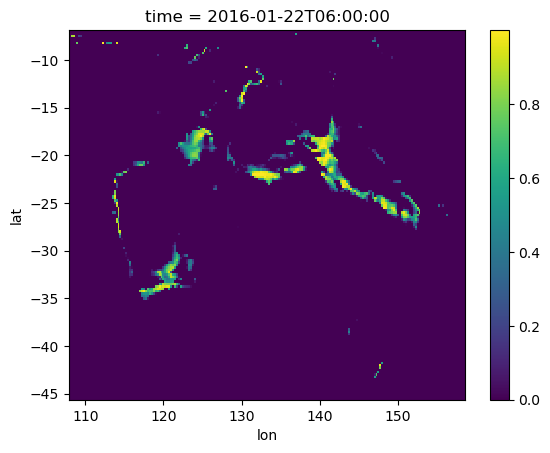

In [25]:
sbi.max(vert_coord).isel(time=18).plot()

In [60]:
wind_ds.isel(lev=10,time=10).height_var.values

array([[433.3332, 433.3332, 433.3332, ..., 433.3332, 433.3332, 433.3332],
       [433.3332, 433.3332, 433.3332, ..., 433.3332, 433.3332, 433.3332],
       [433.3332, 433.3332, 433.3332, ..., 433.3332, 433.3332, 433.3332],
       ...,
       [433.3332, 433.3332, 433.3332, ..., 433.3332, 433.3332, 433.3332],
       [433.3332, 433.3332, 433.3332, ..., 433.3332, 433.3332, 433.3332],
       [433.3332, 433.3332, 433.3332, ..., 433.3332, 433.3332, 433.3332]])

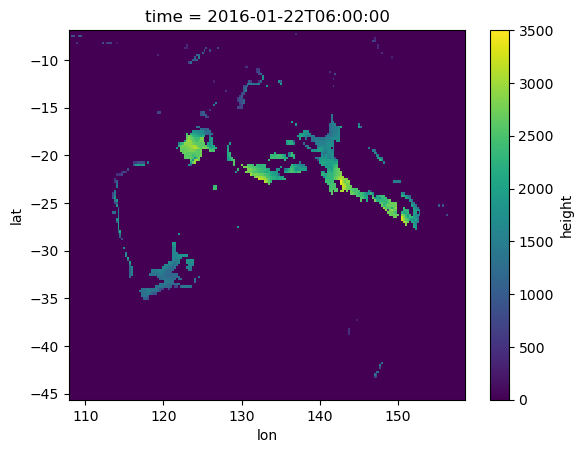

In [28]:
sbi_max_h.isel(time=18).plot()